# Stock Price Prediction 


- **Linear Regression** (baseline model)
- **Random Forest** (ensemble method)
- **Gradient Boosting** (advanced ensemble method)

In [1]:
# 1) Imports
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import yfinance as yf

In [2]:
# 2) Parameters (you can change these)
ticker = "GOOG"      # e.g., 'AAPL', 'MSFT'
period = "1y"        # '6mo', '1y', '2y', '5y'
lags = 5             # number of lag days to use as features
test_size_pct = 20   # percent of most recent data to use for testing

C:\Users\Prakshil\AppData\Local\Temp\ipykernel_16568\2351636950.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, period=period, interval="1d")
[*********************100%***********************]  1 of 1 completed



Price            Close        High         Low        Open    Volume
Ticker            GOOG        GOOG        GOOG        GOOG      GOOG
Date                                                                
2025-10-28  268.429993  271.380005  267.170013  270.200012  20101200
2025-10-29  275.170013  275.970001  268.429993  268.609985  26287900
2025-10-30  281.899994  291.929993  280.450012  291.720001  48570000
2025-10-31  281.820007  286.285004  277.523010  283.204987  29932800
2025-11-03  284.119995  285.940002  280.369995  282.420013  19657000


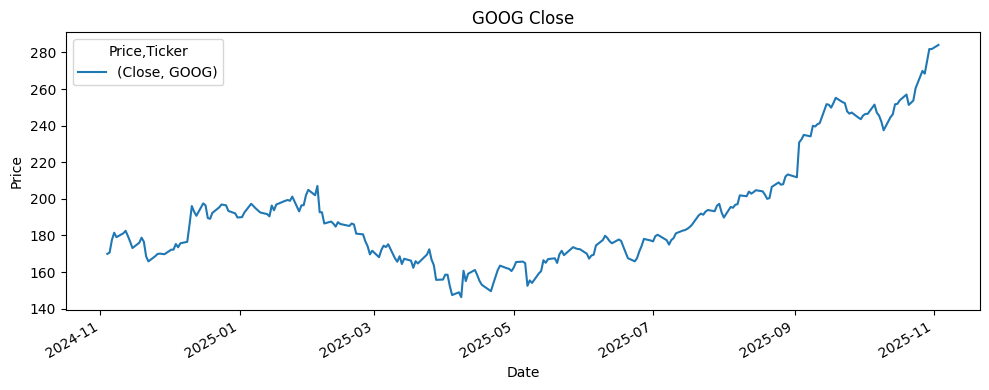

In [3]:
# 3) Download daily data

df = yf.download(ticker, period=period, interval="1d")
if df is None or df.empty:
    raise SystemExit("No data downloaded. Check the ticker or period.")

# Prefer 'Adj Close', else 'Close'
price_col = "Adj Close" if "Adj Close" in df.columns else ("Close" if "Close" in df.columns else None)
if price_col is None:
    raise SystemExit("No 'Adj Close' or 'Close' column found.")

print(df.tail())
df[[price_col]].plot(title=f"{ticker} {price_col}", figsize=(10,4))
plt.xlabel("Date"); plt.ylabel("Price"); plt.tight_layout(); plt.show()

In [ ]:
# 4) Make lag features (supervised dataset)
`
def make_supervised(series: pd.Series, lags: int) -> pd.DataFrame:
    data = pd.DataFrame({"target": series})
    for i in range(1, lags + 1):
        data[f"lag_{i}"] = series.shift(i)
    return data.dropna()

series = df[price_col].squeeze().astype(float)
supervised = make_supervised(series, lags)
print("Rows after lagging:", len(supervised))
if len(supervised) < 20:
    raise SystemExit("Not enough rows after lagging. Reduce 'lags' or increase 'period'.")

Rows after lagging: 245


In [ ]:
# 5) Time-based split (last X% as test) — simplified

test_size = max(1, int(len(supervised) * test_size_pct / 100))
split_idx = len(supervised) - test_size

train = supervised.iloc[:split_idx]
test = supervised.iloc[split_idx:]

drop_cols = supervised.columns.drop("target")
X_train = train[drop_cols].to_numpy()
y_train = train["target"].to_numpy()
X_test = test[drop_cols].to_numpy()
y_test = test["target"].to_numpy()

print(f"Train size: {len(train)}, Test size: {len(test)}")

Train size: 196, Test size: 49


In [6]:
# 6) Fit Linear Regression and evaluate

linreg = LinearRegression()
linreg.fit(X_train, y_train)

pred = linreg.predict(X_test)
rmse = float(np.sqrt(mean_squared_error(y_test, pred)))
mae = float(mean_absolute_error(y_test, pred))
with np.errstate(divide='ignore', invalid='ignore'):
    mape_vals = np.abs((pred - y_test) / np.where(y_test == 0, np.nan, y_test)) * 100.0
    mape = float(np.nanmean(mape_vals))

print(f"RMSE: {rmse:,.4f}")
print(f"MAE:  {mae:,.4f}")
print(f"MAPE: {mape:,.2f}%")

RMSE: 5.0800
MAE:  3.6079
MAPE: 1.45%


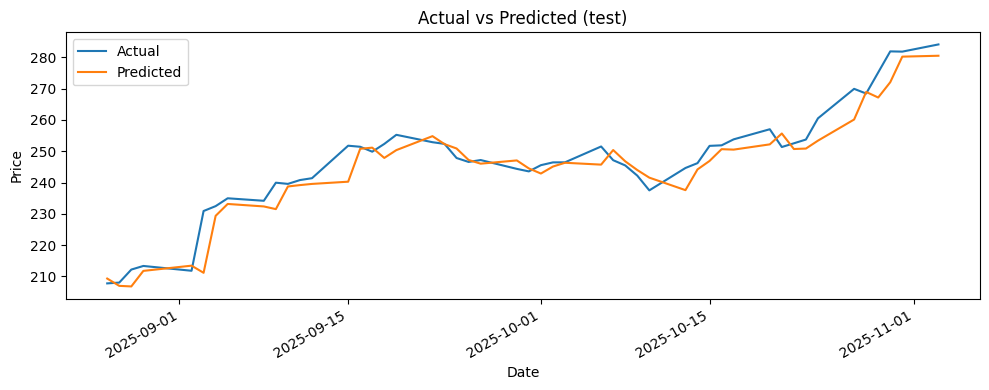

In [7]:
# 7) Visualize Actual vs Predicted (test)

ax = pd.DataFrame({
    "Actual": y_test,
    "Predicted": pred,
}, index=test.index).plot(figsize=(10,4), title="Actual vs Predicted (test)")
plt.xlabel("Date"); plt.ylabel("Price"); plt.tight_layout(); plt.show()

In [ ]:
# 8) Predict next day's close price

latest_lags = [series.iloc[-i] for i in range(1, lags + 1)]
latest_X = np.array(latest_lags).reshape(1, -1)
next_day_pred = float(linreg.predict(latest_X)[0])
print(f"Predicted next close for {ticker}: {next_day_pred:,.2f}")

Predicted next close for GOOG: 281.40


In [ ]:
# 13) Residual analysis for the best model

best_predictions = best_result["Predictions"]
residuals = y_test - best_predictions

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Residual plot over time
axes[0].plot(test.index, residuals, color='red', alpha=0.6)
axes[0].axhline(0, color='black', linestyle='--', linewidth=1.5)
axes[0].set_title(f"Residuals Over Time ({best_model_name})", fontweight='bold')
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Residual (Actual - Predicted)")
axes[0].grid(True, alpha=0.3)

# Residual distribution histogram
axes[1].hist(residuals, bins=30, color='steelblue', alpha=0.7, edgecolor='black')
axes[1].axvline(0, color='red', linestyle='--', linewidth=2)
axes[1].set_title(f"Residual Distribution ({best_model_name})", fontweight='bold')
axes[1].set_xlabel("Residual")
axes[1].set_ylabel("Frequency")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Mean Residual: {np.mean(residuals):,.4f}")
print(f"Std Dev of Residuals: {np.std(residuals):,.4f}")

In [ ]:
# 12) Best model selection and next-day predictions

# Find the best model based on RMSE
best_result = min(results, key=lambda x: x["RMSE"])
best_model_name = best_result["Model"]
best_model = models[best_model_name]

print(f"🏆 Best Model: {best_model_name}")
print(f"   RMSE: {best_result['RMSE']:,.4f}")
print(f"   R² Score: {best_result['R² Score']:,.4f}")
print(f"   Accuracy: {best_result['Accuracy (%)']:,.2f}%")

# Make next-day predictions with all models
latest_lags = [series.iloc[-i] for i in range(1, lags + 1)]
latest_X = np.array(latest_lags).reshape(1, -1)
latest_X_scaled = scaler.transform(latest_X)

print(f"\n📈 Next-Day Predictions for {ticker}:")
print("-" * 50)
for name, model in models.items():
    if name == "Linear Regression":
        next_pred = float(model.predict(latest_X)[0])
    else:
        next_pred = float(model.predict(latest_X_scaled)[0])
    print(f"  {name:20s}: ${next_pred:,.2f}")
    
print("\n" + "="*50)
if best_model_name == "Linear Regression":
    recommended = best_model.predict(latest_X)[0]
else:
    recommended = best_model.predict(latest_X_scaled)[0]
print(f"🎯 RECOMMENDED (Best Model): ${recommended:,.2f}")
print("="*50)

In [ ]:
# 11) Visualize predictions from all models

fig, ax = plt.subplots(figsize=(14, 6))

# Plot actual values
ax.plot(test.index, y_test, label="Actual", linewidth=2.5, color='black', alpha=0.8)

# Plot predictions from each model
colors = ['blue', 'green', 'orange']
linestyles = ['--', '-.', ':']

for i, result in enumerate(results):
    ax.plot(test.index, result["Predictions"], 
            label=f"{result['Model']} (RMSE: {result['RMSE']:.2f})",
            linestyle=linestyles[i], 
            linewidth=1.5,
            color=colors[i],
            alpha=0.7)

ax.set_title(f"Model Comparison: Actual vs Predicted for {ticker}", fontsize=14, fontweight='bold')
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Price", fontsize=12)
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# 10) Evaluate all models and compare performance
from sklearn.metrics import r2_score

results = []

for name, model in models.items():
    if name == "Linear Regression":
        pred = model.predict(X_test)
    else:
        pred = model.predict(X_test_scaled)
    
    # Calculate metrics
    rmse = float(np.sqrt(mean_squared_error(y_test, pred)))
    mae = float(mean_absolute_error(y_test, pred))
    
    with np.errstate(divide='ignore', invalid='ignore'):
        mape_vals = np.abs((pred - y_test) / np.where(y_test == 0, np.nan, y_test)) * 100.0
        mape = float(np.nanmean(mape_vals))
    
    accuracy = 100 - mape
    
    # R² Score using sklearn
    r2 = r2_score(y_test, pred)
    
    results.append({
        "Model": name,
        "RMSE": rmse,
        "MAE": mae,
        "MAPE": mape,
        "Accuracy (%)": accuracy,
        "R² Score": r2,
        "Predictions": pred
    })
    
    print(f"\n{name}:")
    print(f"  RMSE: {rmse:,.4f}")
    print(f"  MAE:  {mae:,.4f}")
    print(f"  MAPE: {mape:,.2f}%")
    print(f"  Accuracy: {accuracy:,.2f}%")
    print(f"  R² Score: {r2:,.4f}")

# Create comparison DataFrame
comparison_df = pd.DataFrame([{k: v for k, v in r.items() if k != "Predictions"} for r in results])
print("\n" + "="*70)
print("📊 MODEL COMPARISON:")
print("="*70)
print(comparison_df.to_string(index=False))

In [ ]:
# 9) Import additional models and preprocessing
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

# Feature Scaling (important for tree-based models' consistency)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize models with tuned hyperparameters
models = {
    "Linear Regression": linreg,  # Already trained (no scaling needed for LinReg with these features)
    
    "Random Forest": RandomForestRegressor(
        n_estimators=300,           # Number of trees
        max_depth=15,               # Maximum depth of trees
        min_samples_split=5,        # Minimum samples to split a node
        min_samples_leaf=2,         # Minimum samples in leaf node
        max_features='sqrt',        # Number of features to consider for best split
        bootstrap=True,             # Bootstrap sampling
        random_state=42,
        n_jobs=-1,                  # Use all CPU cores
        oob_score=True              # Out-of-bag score for validation
    ),
    
    "Gradient Boosting": GradientBoostingRegressor(
        n_estimators=200,           # Number of boosting stages
        learning_rate=0.05,         # Shrinks contribution of each tree
        max_depth=4,                # Maximum depth of individual trees
        min_samples_split=5,        # Minimum samples to split a node
        min_samples_leaf=3,         # Minimum samples in leaf node
        subsample=0.8,              # Fraction of samples for fitting trees (prevents overfitting)
        max_features='sqrt',        # Number of features to consider
        random_state=42,
        validation_fraction=0.1,    # Fraction of training data for early stopping
        n_iter_no_change=10,        # Stop if no improvement for 10 iterations
        tol=1e-4                    # Tolerance for early stopping
    )
}

# Train Random Forest and Gradient Boosting with scaled data
print("Training Random Forest...")
models["Random Forest"].fit(X_train_scaled, y_train)
print(f"  ✓ OOB Score: {models['Random Forest'].oob_score_:.4f}")

print("Training Gradient Boosting...")
models["Gradient Boosting"].fit(X_train_scaled, y_train)
print(f"  ✓ Training complete!")
print("\n✅ All models trained!")

# Feature importance for tree-based models
print("\n📊 Feature Importances:")
print("-" * 50)
for name in ["Random Forest", "Gradient Boosting"]:
    importances = models[name].feature_importances_
    feature_names = [f"lag_{i}" for i in range(1, lags + 1)]
    
    print(f"\n{name}:")
    for fname, importance in sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True):
        print(f"  {fname}: {importance:.4f}")